<img src="blackfriday.png" width=700 height=500>

# Predicting The Amount Of Purchase On Black Friday
##### Minh Truong, Yunhan Bai, David Hook 
### -----------------------------------------------------------------------------------------------------------------------------------------------------------------
## Introduction
For millions of people Black Friday is the time to do some serious Christmas shopping --even before the last of the Thanksgiving leftovers are gone! Black Friday is the Friday after Thanksgiving, and it's one of the major shopping days of the year in the United States, falling anywhere between November 23 and 29. While it's not recognized as an official U.S. holiday, many employees have the day off, except those working in retail.
<br><br>
In this tutorial, our goal is .....


# Getting Started with the Data
<br>We make use of Python 3 along with a few imported libraries: <a href="http://pandas.pydata.org/pandas-docs/stable/">pandas</a>, <a href="http://www.numpy.org/">numpy</a>, <a href="https://matplotlib.org/tutorials/index.html">matplotlib</a>, <a href="https://scikit-learn.org/stable/">scikit-learn</a>, <a href="https://seaborn.pydata.org/">seaborn</a>, and more.

In [1]:
# Necessary libraries and imports to complete this tutorial
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
import seaborn as sns
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

# Reading the data

In [2]:
blackfriday = pd.read_csv("blackfriday.csv")
#Making Mean_age so for graphing in later sections
blackfriday['Mean_age'] = blackfriday['Age'].map({'0-17': 8.5, '18-25': 21.5,'26-35': 30.5, '36-45': 40.5,'46-50': 48, '51-55': 53, '55+': 67.5})
#Modify the "Stay_In_Current_City_Years" column, so assume that anyone that live more than 4 years is just 4 years.
blackfriday['Stay_In_Current_City_Years'] = blackfriday['Stay_In_Current_City_Years'].map({'0': 0, '1': 1, '2': 2, '3': 3,'4+': 4})
blackfriday.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Mean_age
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,8.5
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,8.5
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422,8.5
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057,8.5
4,1000002,P00285442,M,55+,16,C,4,0,8,NaN,NaN,7969,67.5


In the above dataset, there are 12 columns in total. We have: <br>
Column 1: User_ID <br>
Column 2: Product_ID  <br>
Column 3: Gender (Male and Female) <br>
Column 4: Age (Age in bins) <br>
Column 5: Occupation <br>
Column 6: City_Category (A, B, C) <br>
Column 7: Stay_In_Current_City_Years (Number of years stay in current city) <br>
Column 8: Marital_Status (0 for single, 1 for married) <br>
Column 9: Product_Category_1 <br>
Column 10: Product_Category_2 <br>
Column 11: Product_Category_3 <br>
Column 12: Purchase (Purchase amount in Dollars) <br>
Column 13: Mean_Age (mean of the age bins)<br>
<br>
A product can belong to many different categories.<br>

# Tidying and modifying the data

<b> In tidy data: </b>
<br> 1. Each variable forms a column.
<br> 2. Each observation forms a row.
<br> 3. Each type of observational unit forms a table.

Tell us why do you need to tidy the data. What are your purposes to use them?

Handling missing data. <br>
As we notice, our missing data is in the product category columns. Therefore, we are going to replace them by 0 to let people know that product does not have different categories. 

In [3]:
blackfriday = blackfriday.fillna(0)
blackfriday.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Mean_age
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370,8.5
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,8.5
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422,8.5
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,0.0,1057,8.5
4,1000002,P00285442,M,55+,16,C,4,0,8,0.0,0.0,7969,67.5


Another step in tidying data is to remove variables from column names. <br>In our example, Product_Category_1, Product_Category_2, and Product_Category_3 should be melted to one column. <br>To keep the original dataframe clear and have fewer repeat information, we create a new dataframe to store Product_Category seperately. <br>Item category can be looked up with its Product_ID in the new dataframe.

In [4]:
# Create a seperate dataframe to store category infomation
category_table = blackfriday[['Product_ID', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']]
# Drop Product_Category columns from the original dataframe for neatness
blackfriday = blackfriday.drop(['Product_Category_1', 'Product_Category_2', 'Product_Category_3'], axis=1)

# Melt Product_Category columns in to one
category_table = pd.melt(category_table, id_vars=['Product_ID'], value_vars=['Product_Category_1', 'Product_Category_2', 'Product_Category_3'])
# Drop any row with value equals to 0 (no category)
category_table = category_table[category_table.value != 0]   
# Drop variable column
category_table = category_table.drop(['variable'], axis=1)
# Rename value column to Product_Category
category_table = category_table.rename(index=str, columns={"value": "Product_Category"})
category_table.head()

,Product_ID,Product_Category
0,P00069042,3.0
1,P00248942,1.0
2,P00087842,12.0
3,P00085442,12.0
4,P00285442,8.0


# Exploratory Data Analysis (EDA)

#### Four types of EDA
- Univariate non-graphical
- Multivariate non-graphical
- Univariate graphical
- Multivariate graphical

#### Advantages of EDA:
- Detection of mistakes
- Checking of assumptions
- Preliminary selection of appropriate models
- Determining relationships among the explanatory variables
- Assessing the direction and rough size of relationships between explanatory and outcome variables

Groups data by age

In [5]:
groups = blackfriday.groupby(['User_ID', 'Mean_age']).agg({'Purchase': np.sum}).reset_index()
#0-17
print('group 0-17 total purchase')
display(groups[groups.Mean_age == 8.5].head())
#18-25
print('group 18-25 total purchase')
display(groups[groups.Mean_age == 21.5].head())
#26-35
print('group 26-35 total purchase')
display(groups[groups.Mean_age == 30.5].head())
#36-45
print('group 36-45 total purchase')
display(groups[groups.Mean_age == 40.5].head())
#46-50
print('group 46-50 total purchase')
display(groups[groups.Mean_age == 48].head())
#51-55
print('group 51-55 total purchase')
display(groups[groups.Mean_age == 53].head())
#55+
print('group 55+ total purchase')
display(groups[groups.Mean_age == 67.5].head())

group 0-17 total purchase


,User_ID,Mean_age,Purchase
0,1000001,8.5,333481
18,1000019,8.5,1457938
48,1000051,8.5,200772
72,1000075,8.5,1035228
83,1000086,8.5,294050


group 18-25 total purchase


,User_ID,Mean_age,Purchase
17,1000018,21.5,1978675
20,1000021,21.5,126744
21,1000022,21.5,1279678
24,1000025,21.5,534215
33,1000034,21.5,807747


group 26-35 total purchase


,User_ID,Mean_age,Purchase
2,1000003,30.5,341635
4,1000005,30.5,821001
7,1000008,30.5,796545
8,1000009,30.5,593960
10,1000011,30.5,556902


group 36-45 total purchase


,User_ID,Mean_age,Purchase
6,1000007,40.5,234427
9,1000010,40.5,2169486
13,1000014,40.5,127629
15,1000016,40.5,150428
22,1000023,40.5,1670998


group 46-50 total purchase


,User_ID,Mean_age,Purchase
3,1000004,48.0,205987
12,1000013,48.0,713927
32,1000033,48.0,1940043
34,1000035,48.0,821303
41,1000044,48.0,1180380


group 51-55 total purchase


,User_ID,Mean_age,Purchase
5,1000006,53.0,379450
16,1000017,53.0,1425501
51,1000054,53.0,187201
56,1000059,53.0,980068
57,1000060,53.0,279980


group 55+ total purchase


,User_ID,Mean_age,Purchase
1,1000002,67.5,810353
30,1000031,67.5,496154
77,1000080,67.5,339119
86,1000089,67.5,112226
87,1000090,67.5,1310621


Compute the sum of purchase for a user

In [6]:
total_purchase_of_an_user = blackfriday.groupby('User_ID').agg({'Purchase': np.sum})
total_purchase_of_an_user.reset_index(inplace=True)
total_purchase_of_an_user.head()

,User_ID,Purchase
0,1000001,333481
1,1000002,810353
2,1000003,341635
3,1000004,205987
4,1000005,821001


Compute the sum of a purchase for a product

In [7]:
total_purchase_of_a_product = blackfriday.groupby('Product_ID').agg({'Purchase': np.sum})
total_purchase_of_a_product.reset_index(inplace=True)
total_purchase_of_a_product.head()

,Product_ID,Purchase
0,P00000142,12592163
1,P00000242,3914901
2,P00000342,1261383
3,P00000442,441173
4,P00000542,791219


Compute the frequency of a product that is purchased within a group

In [84]:
freq_purchase =  blackfriday.groupby(['Product_ID']).Product_ID.count().to_frame()
freq_purchase['freq'] = freq_purchase.Product_ID
freq_purchase = freq_purchase.drop(columns=['Product_ID'], axis=1)
freq_purchase.reset_index(level=0, inplace=True)
freq_purchase.head()

,Product_ID,freq
0,P00000142,1130
1,P00000242,371
2,P00000342,238
3,P00000442,92
4,P00000542,146


Merge the two tables: freq_purchase and total_purchase_of_a_product

In [85]:
freq_purchase = freq_purchase.merge(total_purchase_of_a_product, left_on='Product_ID', right_on='Product_ID', how='outer')
freq_purchase.head()

,Product_ID,freq,Purchase
0,P00000142,1130,12592163
1,P00000242,371,3914901
2,P00000342,238,1261383
3,P00000442,92,441173
4,P00000542,146,791219


# Doing a graph for frequency and purchase

# Doing a graph for an age and the amount of purchase

# Doing a graph for an city_category and the amount of purchase

# Graphing Frequency Distribution of Product Categories

Text(0,0.5,'Counts')

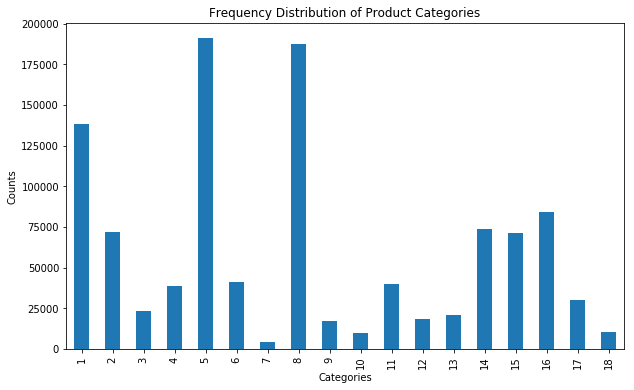

In [109]:
# Create a frequency table of Product_Category from category_table
freq_category = category_table.groupby('Product_Category').count()
freq_category.drop(['Product_ID'], axis=1).reset_index(level=0, inplace=True)
# Plotting the distribution with bar chart
ax=freq_category.plot(kind='bar', legend=False, figsize=(10,6))
ax.set_xticklabels(range(1,19))
ax.set_title("Frequency Distribution of Product Categories")
ax.set_xlabel("Categories")
ax.set_ylabel("Counts")

# Doing a graph for an age and the category

# Do hypothesis testing for the mean of different groups of age

# Linear Regression 
Occupation and Age

# Logistic Regression
Male vs Female 
Single vs Married
